# Packages

In [9]:
import plotly.express as px
import pandas as pd
from google.cloud import bigquery
import numpy as np
from datetime import time, timedelta, datetime
import math 
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ipywidgets
import statsmodels.stats.weightstats as sw
from statsmodels.stats.proportion import test_proportions_2indep
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
from google.cloud import bigquery
from scipy.stats import norm
from scipy import stats
pd.options.display.float_format = "{:,.2f}".format
from scipy.stats import norm
from scipy import stats
import statsmodels.stats.weightstats as ws
import openpyxl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ambrosia.designer import Designer

# df["Week"] = df["Date"].dt.to_period("W").dt.to_timestamp()

bigquery_client = bigquery.Client(project='analytics-dev-333113')

def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                          )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                          )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                          )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                          )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                      )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                      )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                  )

        print('DataFrame is written to Excel File successfully.')

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

# Research

### Haversine metric

In [ ]:
import pandas as pd
from haversine import haversine, Unit
from datetime import datetime
from io import StringIO

data = """
Timestamp,Latitude,Longitude,Height
2024-11-05 17:50:52.000000,42.8196288,74.6142683,842.3999633789062
2024-11-05 17:51:08.000000,42.8196311,74.6142595,842.3999633789062
2024-11-05 17:51:20.000000,42.8196313,74.6142598,842.3999633789062
2024-11-05 17:51:36.000000,42.8196313,74.6142602,842.3999633789062
2024-11-05 17:51:52.000000,42.8196309,74.6142604,842.3999633789062
2024-11-05 17:52:08.000000,42.8196311,74.6142606,842.3999633789062
2024-11-05 17:52:24.000000,42.8196311,74.6142602,842.3999633789062
2024-11-05 17:52:36.000000,42.8196544,74.6142856,842.3999633789062
2024-11-05 17:52:52.000000,42.8196482,74.6142859,842.3999633789062
2024-11-05 17:53:08.000000,42.8196491,74.6142842,842.3999633789062
2024-11-05 17:53:24.000000,42.8196537,74.6142752,842.3999633789062
2024-11-05 17:53:38.000000,42.8196555,74.6142704,842.3999633789062
2024-11-05 17:53:52.000000,42.8196557,74.6142702,842.3999633789062
2024-11-05 17:54:08.000000,42.8196621,74.6142909,842.3999633789062
2024-11-05 17:54:12.000000,42.8196122,74.6142342,842.3999633789062
2024-11-05 17:54:16.000000,42.8196778,74.6142975,842.3999633789062
2024-11-05 17:54:24.000000,42.8196091,74.6141776,842.3999633789062
2024-11-05 17:54:40.000000,42.8196136,74.614178,842.3999633789062
2024-11-05 17:54:56.000000,42.8196129,74.6141745,842.3999633789062
2024-11-05 17:55:12.000000,42.8196168,74.6141711,842.3999633789062
2024-11-05 17:55:12.000000,42.8196168,74.6141711,842.3999633789062
2024-11-05 17:55:24.000000,42.8196185,74.6141692,842.3999633789062
2024-11-05 17:55:24.000000,42.8196185,74.6141692,842.3999633789062
2024-11-05 17:55:40.000000,42.819621,74.6141662,842.3999633789062
2024-11-05 17:55:40.000000,42.819621,74.6141662,842.3999633789062
2024-11-05 17:55:56.000000,42.8196219,74.6141646,842.3999633789062
2024-11-05 17:55:56.000000,42.8196219,74.6141646,842.3999633789062
2024-11-05 17:56:12.000000,42.8196233,74.6141619,842.3999633789062
2024-11-05 17:56:12.000000,42.8196233,74.6141619,842.3999633789062
2024-11-05 17:56:28.000000,42.8196239,74.6141591,842.3999633789062
2024-11-05 17:56:28.000000,42.8196239,74.6141591,842.3999633789062
2024-11-05 17:56:40.000000,42.8196241,74.6141589,842.3999633789062
2024-11-05 17:56:40.000000,42.8196241,74.6141589,842.3999633789062
2024-11-05 17:56:56.000000,42.8196243,74.6141591,842.3999633789062
2024-11-05 17:56:56.000000,42.8196243,74.6141591,842.3999633789062
2024-11-05 17:57:16.000000,42.8196249,74.614159,842.3999633789062
2024-11-05 17:57:16.000000,42.8196249,74.614159,842.3999633789062
"""

df = pd.read_csv(StringIO(data), 
                 parse_dates=["Timestamp"])

print(df.head())

# Sorting by time
df.sort_values('Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

total_distance = 0.0  # Total distance in meters
total_time = 0.0      # Total time in seconds
speeds = []            # Velocity between points
distances = []        # Distance between points

# Velocity and distance calculation
for i in range(len(df) - 1):
    point1 = (df.loc[i, "Latitude"], df.loc[i, "Longitude"])
    point2 = (df.loc[i + 1, "Latitude"], df.loc[i + 1, "Longitude"])
    
    # Distance between points
    distance = haversine(point1, point2, unit=Unit.METERS)
    distances.append(distance)
    total_distance += distance
    
    # Time between points
    delta_time = (df.loc[i + 1, "Timestamp"] - df.loc[i, "Timestamp"]).total_seconds()
    total_time += delta_time
    
    # Elimination of dividing by zero
    if delta_time > 0:
        speed = distance / delta_time  # м/с
    else:
        speed = 0.0
    speeds.append(speed)

# Adding to dataframe
df['Distance_m'] = [0.0] + distances
df['Delta_Time_s'] = [0.0] + [ (df.loc[i + 1, "Timestamp"] - df.loc[i, "Timestamp"]).total_seconds() for i in range(len(df) -1)]
df['Speed_m_s'] = [0.0] + speeds

# Mean velocity calc
average_speed = total_distance / total_time if total_time > 0 else 0.0

# Distance between first and last points
start_point = (df.loc[0, "Latitude"], df.loc[0, "Longitude"])
end_point = (df.loc[len(df) - 1, "Latitude"], df.loc[len(df) - 1, "Longitude"])
direct_distance = haversine(start_point, end_point, unit=Unit.METERS)
deviation = total_distance - direct_distance

# Mean speed between points calculation
max_speed = np.mean(speeds) if speeds else 0.0

# Conclusion
print("\nConclusion:")
print(f"Общее пройденное расстояние: {total_distance:.2f} meters")
print(f"Общее время движения: {total_time:.2f} seconds")
print(f"Средняя скорость: {average_speed:.2f} м/s")
print(f"Прямое расстояние между начальной и конечной точками: {direct_distance:.2f} meters")
print(f"Отклонение от прямой линии: {deviation:.2f} meters")
print(f"Mean speed: {max_speed:.2f} м/s")

### Start / Stop vehicle within the ride

In [126]:
# Andreys logic
query_share_of_detectable_incidents = """
WITH incidents AS (SELECT redmine_id
                        , incident_date
                        , vertical
                        , aggressor
                        , incident_type
                        , category
                        , city_id
                        , city_name
                        , pass_id
                        , order_date
                        , driver_id
                        , CASE
                              WHEN aggressor = 'Driver' THEN driver_id
                              ELSE pass_id
        END agressor_id
                   FROM indriver-bi.safety.vw_safety_incidents_detail
                   WHERE incident_date >= '2024-09-25'
                     AND information_status = 'Confirmed'),
     stops AS (SELECT ride_uuid,
                      contractor_id,
                      customer_id,
                      deviation_type,
                      DATE(create_at)      AS create_at,
                      MAX(deviation_level) AS max_deviation_level
               FROM indriver-e6e40.ods_in_trip_monitoring_cdc.ride_deviation_global
               WHERE deviation_type = 'DEVIATION_TYPE_RIDE_STOP'
                 AND DATE(create_at) = '{date}'
               GROUP BY 1, 2, 3, 4, 5),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part = '{date}')
SELECT t1.*,
       t3.order_city_id,
       t3.order_country_id,
       t2.redmine_id,
       t2.aggressor,
       t2.pass_id,
       t2.driver_id,
       t2.city_id,
       t2.city_name,
       t2.category
FROM stops t1
         JOIN rides t3
              ON t1.contractor_id = t3.driver_id
                  AND t1.customer_id = t3.pass_id
                  AND DATE(t1.create_at) = DATE(t3.driverstarttheride_timestamp)
         LEFT JOIN incidents t2
                    ON t1.contractor_id = t2.driver_id AND t1.customer_id = t2.pass_id
                        AND DATE(t1.create_at) = t2.order_date
WHERE order_city_id IN
      (5257, 5513, 5388, 4242, 4755, 5396, 4373, 4257, 169, 10155, 5548, 4269, 4524, 4143, 4142, 23233, 5698, 6083,
       5957, 4300, 4559, 4825, 4197, 4199, 4200, 22386, 22654)
"""

df_share_of_detectable_incidents = cycle_sql('2024-10-01', '2024-12-10', query_share_of_detectable_incidents)
# df_share_of_detectable_incidents['has_incident'] = df_share_of_detectable_incidents.apply(lambda row: 1 if row['redmine_id'] != None else 0, axis=1)


df_share_of_detectable_incidents.head()


# Most interesting and valuable cities where we can have a look at cases during the ride: 5548, 4300, 4199, 4197, 169, 4373, 4524, 4142


Uploading - 2024-10-01: 2024-12-13 11:08:16
Uploading - 2024-10-02: 2024-12-13 11:09:25
Uploading - 2024-10-03: 2024-12-13 11:10:29
Uploading - 2024-10-04: 2024-12-13 11:11:31
Uploading - 2024-10-05: 2024-12-13 11:12:38
Uploading - 2024-10-06: 2024-12-13 11:13:38
Uploading - 2024-10-07: 2024-12-13 11:14:32
Uploading - 2024-10-08: 2024-12-13 11:15:42
Uploading - 2024-10-09: 2024-12-13 11:16:45
Uploading - 2024-10-10: 2024-12-13 11:17:47
Uploading - 2024-10-11: 2024-12-13 11:18:43
Uploading - 2024-10-12: 2024-12-13 11:19:43
Uploading - 2024-10-13: 2024-12-13 11:20:36
Uploading - 2024-10-14: 2024-12-13 11:21:23
Uploading - 2024-10-15: 2024-12-13 11:22:17
Uploading - 2024-10-16: 2024-12-13 11:23:18
Uploading - 2024-10-17: 2024-12-13 11:24:10
Uploading - 2024-10-18: 2024-12-13 11:25:08
Uploading - 2024-10-19: 2024-12-13 11:26:06
Uploading - 2024-10-20: 2024-12-13 11:27:05
Uploading - 2024-10-21: 2024-12-13 11:27:53
Uploading - 2024-10-22: 2024-12-13 11:28:52
Uploading - 2024-10-23: 2024-12-

,ride_uuid,contractor_id,customer_id,deviation_type,create_at,max_deviation_level,order_city_id,order_country_id,redmine_id,aggressor,pass_id,driver_id,city_id,city_name,category
0,0193b234-ebed-72fe-bdf6-d58573678e16,221460998,30038363,DEVIATION_TYPE_RIDE_STOP,2024-12-10,3,4269,25,None,None,<NA>,<NA>,<NA>,None,None
1,0193b1ed-652f-7523-898f-7b27ba22cbfe,221460998,13463554,DEVIATION_TYPE_RIDE_STOP,2024-12-10,1,4269,25,None,None,<NA>,<NA>,<NA>,None,None
2,0193b128-21f9-7dad-abf0-9b5181807287,221460998,223368203,DEVIATION_TYPE_RIDE_STOP,2024-12-10,1,4269,25,None,None,<NA>,<NA>,<NA>,None,None
3,0193b281-608a-7850-99c3-f8e5038bbca8,213050889,194294538,DEVIATION_TYPE_RIDE_STOP,2024-12-10,1,4755,11,None,None,<NA>,<NA>,<NA>,None,None
4,0193b158-aef0-7517-be56-dbe389e67db2,213050889,240018055,DEVIATION_TYPE_RIDE_STOP,2024-12-10,1,4755,11,None,None,<NA>,<NA>,<NA>,None,None


<Axes: xlabel='None-max_deviation_level-aggressor', ylabel='category'>

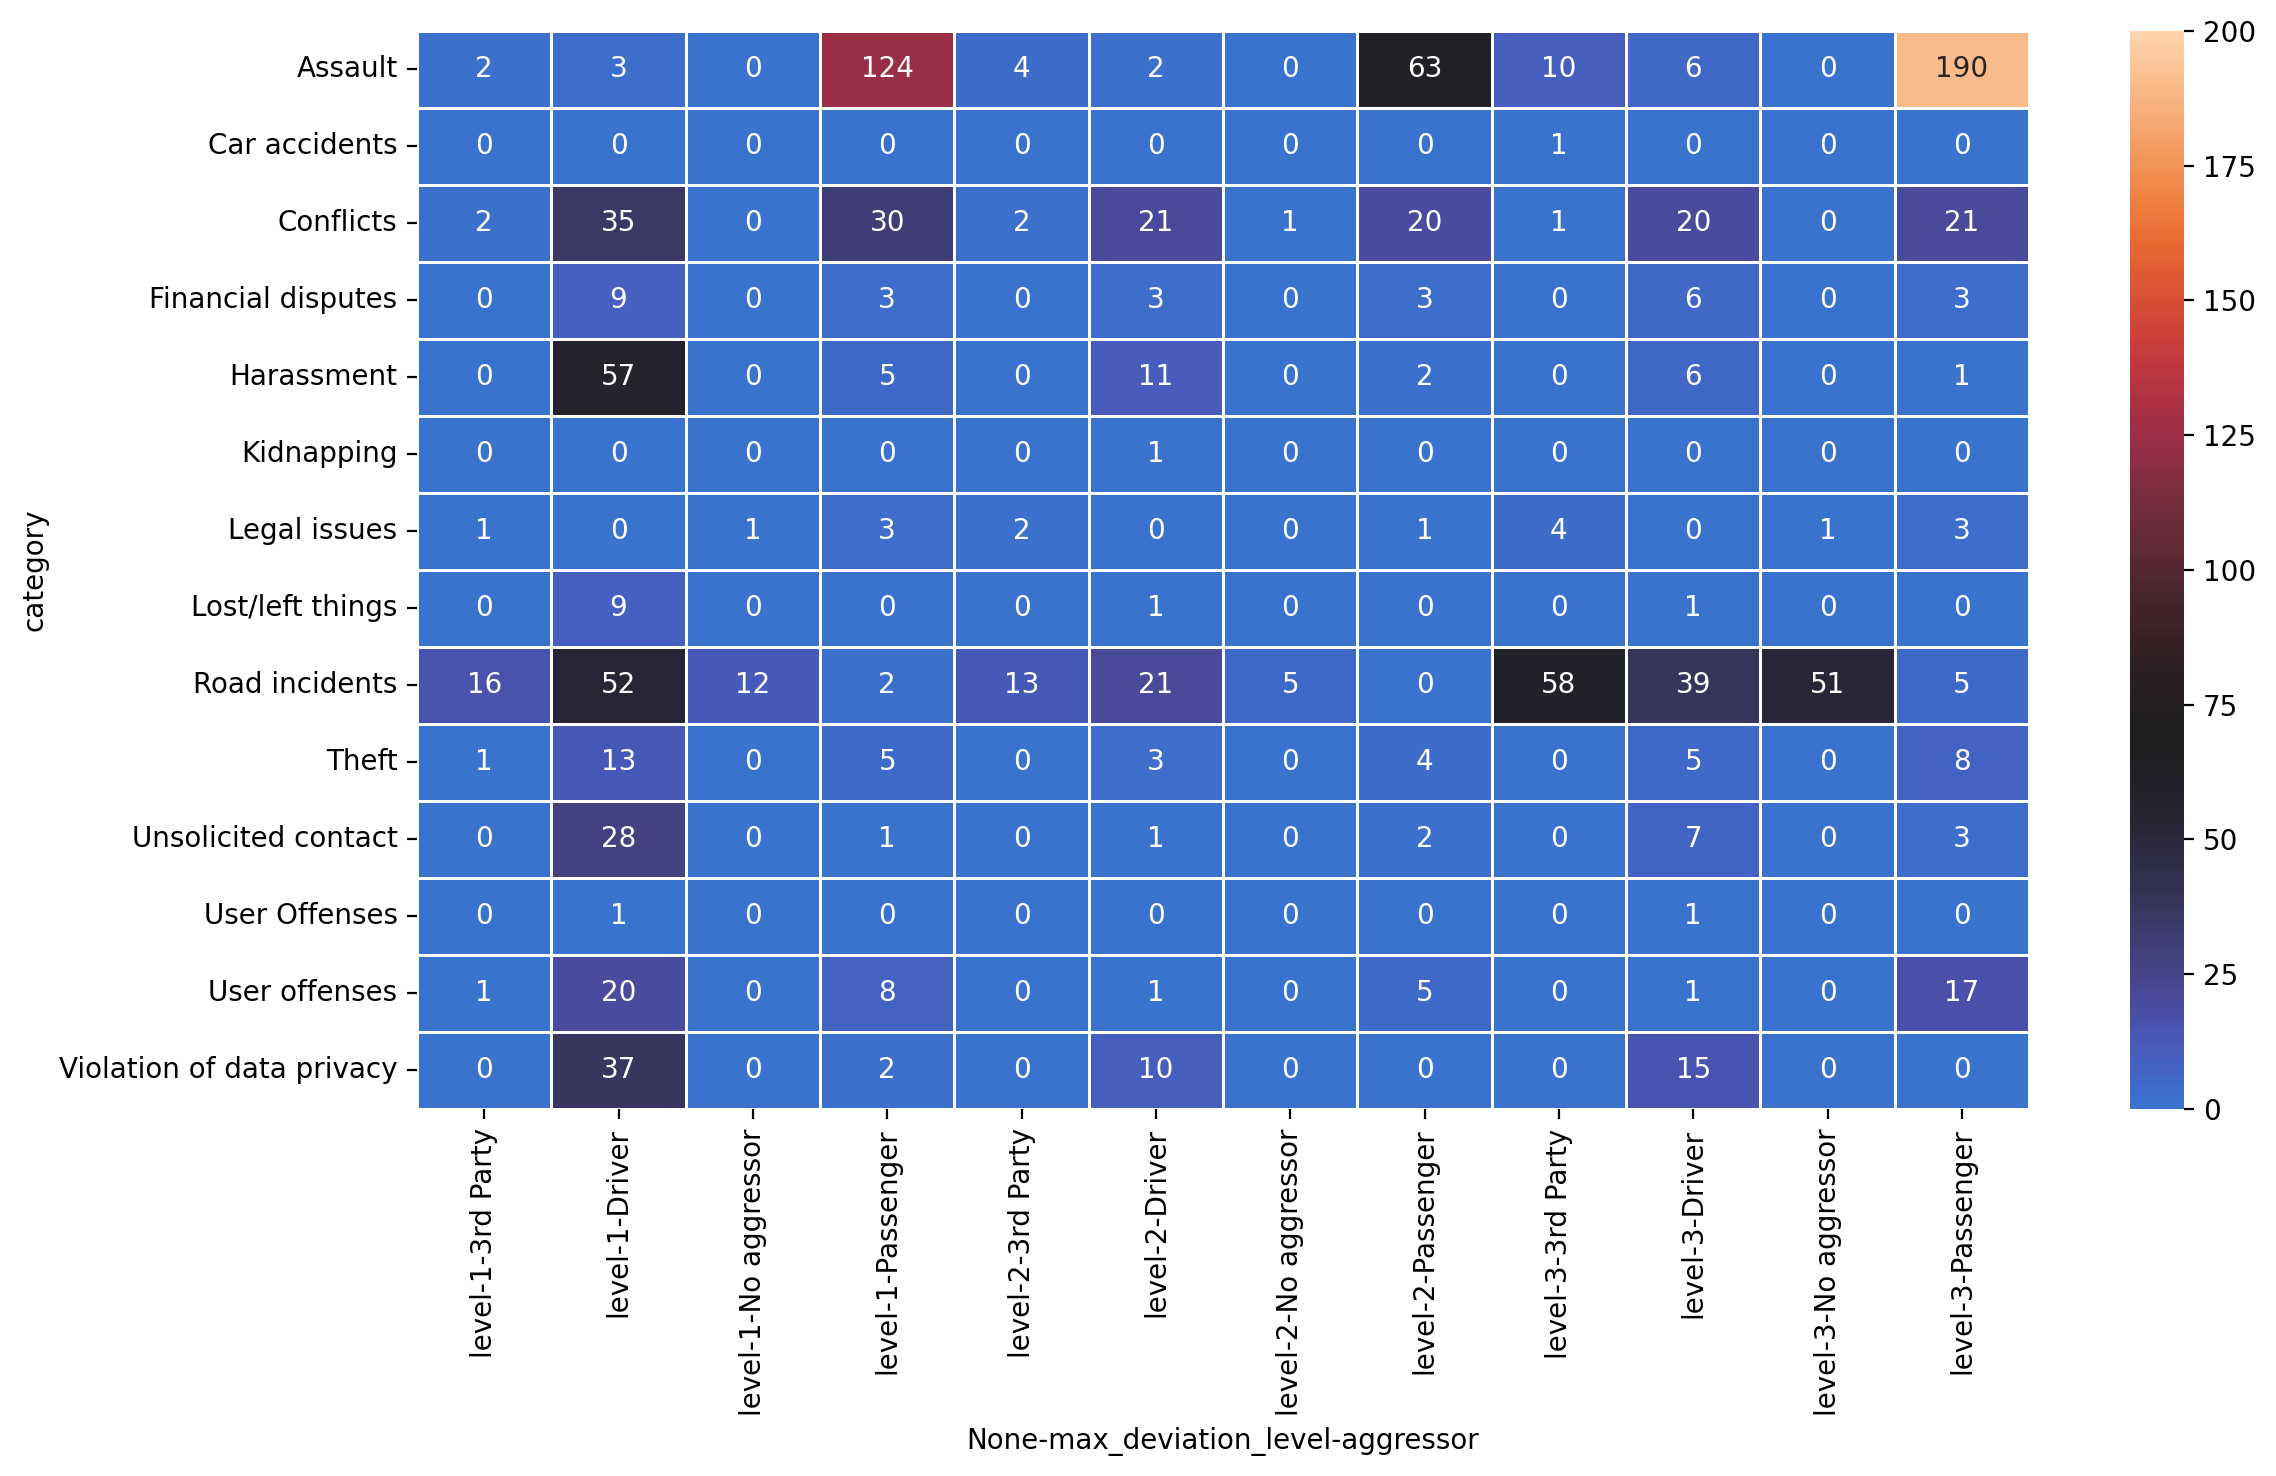

In [160]:
df_andrey_incidents = df_share_of_detectable_incidents[~df_share_of_detectable_incidents.redmine_id.isna()].copy()

fig, ax = plt.subplots(figsize=(13,7)) 

sns.heatmap(df_andrey_incidents.pivot_table(columns=['max_deviation_level', 'aggressor'], index='category', values=['redmine_id'], aggfunc='count').fillna(0).rename(columns={'redmine_id':'level'}).astype('int'), 
            annot=True,
            linewidth=.5,
            # cmap = 'viridis',
            vmin = 0, vmax = 200, center = 70,
            square=False,
            annot_kws={"size": 10},
            fmt='g')



In [153]:
df_share_of_detectable_incidents.groupby(['max_deviation_level'], as_index=False)['ride_uuid', 'redmine_id'].count()


,max_deviation_level,ride_uuid,redmine_id
0,1,23326412,483
1,2,3800232,202
2,3,1073962,484


In [3]:
(484/1073962)

0.0004506677145001406

In [81]:
# Logic of mine - нужно засунуть инциденты в табличку с ордерами и брать инциденты от туда, попробовать реализовать такую логику
query_stop_vehicle = ("""
WITH logs AS (SELECT user_id,
                     created_dttm,
                     created_dt_part,
                     latitude,
                     longitude,
                     altitude,
                     speed,
                     ROUND(speed, 0)         AS speed_rounded,
                     (speed * 3.6)           AS km_h,
                     ROUND((speed * 3.6), 0) AS km_h_rounded,
                     city_id,
                     heading
              FROM indriver-e6e40.imart.set_location_global
              WHERE created_dt_part = '{date}'
                AND city_id = {city})
   , ride AS (SELECT order_uuid,
                     user_id    AS pass_id,
                     driver_id,
                     city_id    AS order_city_id,
                     country_id AS order_country_id,
                     status_order,
                     order_timestamp,
                     at_pickup_dttm,
                     departed_pickup_dttm,
                     at_destination_dttm,
                     departed_destination_dttm,
                     driveraccept_timestamp,
                     driverarrived_timestamp,
                     driverstarttheride_timestamp,
                     driverdone_timestamp,
                     clientdone_timestamp,
                     clientcancel_timestamp,
                     drivercancel_timestamp,
                     user_reg_date,
                     driver_reg_date,
                     stage,
                     created_date_order_part,
                     duration_in_seconds
              FROM indriver-e6e40.imart.incity_detail_new_order
              WHERE created_date_order_part = '{date}'
                AND city_id = {city})
   , incidents AS (SELECT redmine_id
                        , incident_date
                        , vertical
                        , aggressor
                        , incident_type
                        , category
                        , city_id
                        , order_date
                        , city_name
                        , pass_id
                        , driver_id
                        , CASE
                              WHEN aggressor = 'Driver' THEN driver_id
                              WHEN aggressor = 'Passenger' THEN pass_id
                              ELSE NULL
        END aggressor_id
                   FROM indriver-bi.safety.vw_safety_incidents_detail
                   WHERE 1 = 1
                     AND incident_date >= '2024-11-01'
                     AND information_status = 'Confirmed')
   , logs_with_rides AS (SELECT DISTINCT *, IF(km_h <= 1.5, 'stopped', 'driven') AS status
                         FROM logs t1
                                  LEFT JOIN ride t2
                                            ON t1.user_id = t2.driver_id
                                                AND t1.created_dt_part = DATE(t2.driverstarttheride_timestamp)
                                                AND (
                                                   (t1.created_dttm BETWEEN t2.departed_pickup_dttm AND t2.at_destination_dttm)
                                                       OR
                                                   (t1.created_dttm BETWEEN t2.driverstarttheride_timestamp AND t2.driverdone_timestamp)
                                                   )
                         WHERE order_uuid IS NOT NULL)
   , GroupedStatus_total AS (SELECT *,
                                    DATE_DIFF(created_dttm, LAG(created_dttm)
                                                                OVER (PARTITION BY user_id, order_uuid, group_number ORDER BY created_dttm),
                                              SECOND) AS time_diff
                             FROM (SELECT *,
                                          CASE
                                              WHEN status = 'stopped'
                                                  THEN MAX(driven_group) OVER (PARTITION BY user_id, order_uuid, driven_group)
                                              ELSE NULL
                                              END AS group_number
                                   FROM (SELECT *,
                                                CASE
                                                    WHEN status = 'stopped'
                                                        THEN ROW_NUMBER() OVER (PARTITION BY user_id, order_uuid, driven_group ORDER BY created_dttm)
                                                    ELSE 0
                                                    END AS stopped_number
                                         FROM (SELECT *,
                                                      SUM(CASE WHEN status = 'driven' THEN 1 ELSE 0 END)
                                                          OVER (PARTITION BY user_id, order_uuid ORDER BY created_dttm) AS driven_group
                                               FROM logs_with_rides))))
   , result_table AS (SELECT user_id,
                             pass_id                                                           AS customer_id,
                             driver_reg_date,
                             user_reg_date,
                             created_dttm,
                             created_dt_part,
                             latitude,
                             longitude,
                             altitude,
                             speed,
                             speed_rounded,
                             km_h,
                             km_h_rounded,
                             status,
                             group_number,
                             COALESCE(time_diff, 0)                                            AS time_diff,
                             COALESCE(
                                     SUM(CASE WHEN status = 'stopped' THEN time_diff ELSE 0 END)
                                         OVER (PARTITION BY user_id, order_uuid, group_number), 0
                             )                                                                 AS stop_duration,
                             MIN(created_dttm)
                                 OVER (PARTITION BY user_id, order_uuid, status, group_number) AS vehicle_stopped_dttm,
                             MAX(created_dttm)
                                 OVER (PARTITION BY user_id, order_uuid, status, group_number) AS vehicle_started_dttm,
                             city_id,
                             order_uuid,
                             order_city_id,
                             order_country_id,
                             order_timestamp,
                             at_pickup_dttm,
                             departed_pickup_dttm,
                             at_destination_dttm,
                             departed_destination_dttm,
                             driveraccept_timestamp,
                             driverarrived_timestamp,
                             driverstarttheride_timestamp,
                             driverdone_timestamp
                      FROM GroupedStatus_total
                      ORDER BY created_dttm)
   , aggregated AS
    (SELECT user_id,
            driver_reg_date,
            customer_id,
            user_reg_date,
            created_dt_part,
            order_uuid,
            order_city_id,
            order_country_id,
            order_timestamp,
            at_pickup_dttm,
            departed_pickup_dttm,
            at_destination_dttm,
            departed_destination_dttm,
            driveraccept_timestamp,
            driverarrived_timestamp,
            driverstarttheride_timestamp,
            driverdone_timestamp,
            status,
            MAX(stop_duration)                  AS max_stop_duration_sec,
            COUNT(DISTINCT group_number)        AS stop_counts,
            ROUND((MAX(stop_duration) / 60), 3) AS minutes,
            ROUND((MAX(stop_duration) / 60), 0) AS minutes_rounded,
            CASE
                WHEN MAX(stop_duration) BETWEEN 0 AND 180 THEN '0-3 min'
                WHEN MAX(stop_duration) BETWEEN 181 AND 360 THEN '3-6 min'
                WHEN MAX(stop_duration) BETWEEN 361 AND 600 THEN '6-10 min'
                WHEN MAX(stop_duration) BETWEEN 601 AND 900 THEN '10-15 min'
                WHEN MAX(stop_duration) BETWEEN 901 AND 1800 THEN '15-30 min'
                ELSE
                    'greater than 30 minutes'
                END
                                                   segments
     FROM result_table
     WHERE status = 'stopped'
     GROUP BY user_id, driver_reg_date, customer_id, user_reg_date, created_dt_part,
              order_uuid, order_city_id, order_country_id, order_timestamp,
              at_pickup_dttm, departed_pickup_dttm, at_destination_dttm,
              departed_destination_dttm, driveraccept_timestamp, driverarrived_timestamp,
              driverstarttheride_timestamp, driverdone_timestamp, status)
SELECT t1.*,
       t3.city_name,
       t3.country_name,
       redmine_id,
       incident_date,
       t2.category,
       aggressor,
       aggressor_id,
       driver_id,
       pass_id
FROM aggregated t1
         JOIN indriver-e6e40.heap.vw_macroregion_mapping t3
              ON t1.order_city_id = t3.city_id
         LEFT JOIN incidents t2
                   ON t1.user_id = t2.driver_id
                       AND t1.customer_id = t2.pass_id
                       AND t1.created_dt_part = t2.order_date
""")

tuple_of_cities = (5548, 4300, 4199, 4197, 169, 4373, 4524, 4142)

date_start = datetime.strptime('2024-11-01', '%Y-%m-%d')
date_end = datetime.strptime('2024-11-15', '%Y-%m-%d')

daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]

df_stop_ride = pd.DataFrame()

for city in tuple_of_cities:
    for date in daterange:
        print(f"Uploading - {city} and {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))

        df = read_bq(query_stop_vehicle.format(date=date, city=city))

        if df.empty == True:
            print('Dataframe is empty')
        
        df_stop_ride = pd.concat([df, df_stop_ride])

        print(df_stop_ride.shape)

Uploading - 5548 and 2024-11-01: 2024-12-12 17:41:29
(42970, 32)
Uploading - 5548 and 2024-11-02: 2024-12-12 17:42:16
(81009, 32)
Uploading - 5548 and 2024-11-03: 2024-12-12 17:42:57
(115263, 32)
Uploading - 5548 and 2024-11-04: 2024-12-12 17:43:35
(141410, 32)
Uploading - 5548 and 2024-11-05: 2024-12-12 17:44:04
(165414, 32)
Uploading - 5548 and 2024-11-06: 2024-12-12 17:44:35
(196928, 32)
Uploading - 5548 and 2024-11-07: 2024-12-12 17:45:13
(231253, 32)
Uploading - 5548 and 2024-11-08: 2024-12-12 17:46:10
(268532, 32)
Uploading - 5548 and 2024-11-09: 2024-12-12 17:46:43
(304096, 32)
Uploading - 5548 and 2024-11-10: 2024-12-12 17:47:19
(335555, 32)
Uploading - 5548 and 2024-11-11: 2024-12-12 17:47:46
(361412, 32)
Uploading - 5548 and 2024-11-12: 2024-12-12 17:48:15
(395539, 32)
Uploading - 5548 and 2024-11-13: 2024-12-12 17:48:52
(430846, 32)
Uploading - 5548 and 2024-11-14: 2024-12-12 17:49:24
(467080, 32)
Uploading - 5548 and 2024-11-15: 2024-12-12 17:50:02
(506858, 32)
Uploading - 

In [125]:
df_stop_ride.groupby(['minutes_rounded'], as_index=False)['order_uuid', 'redmine_id'].count().query("minutes_rounded > 30 and redmine_id > 0")

,minutes_rounded,order_uuid,redmine_id
33,33.00,1154,1
43,43.00,596,1
62,62.00,190,1


In [116]:
df_stop_ride[(df_stop_ride['segments'] == 'greater than 30 minutes') & (df_stop_ride['city_name'] == 'Lima')][['user_id', 'driver_reg_date', 'customer_id', 'user_reg_date',
       'created_dt_part', 'order_uuid', 'order_city_id', 'order_country_id',
       'order_timestamp', 'at_pickup_dttm', 'departed_pickup_dttm',
       'at_destination_dttm', 'departed_destination_dttm',
       'driveraccept_timestamp', 'driverarrived_timestamp',
       'driverstarttheride_timestamp', 'driverdone_timestamp', 'status',
       'max_stop_duration_sec', 'stop_counts', 'minutes', 'minutes_rounded',
       'segments', 'city_name', 'country_name']]

,user_id,driver_reg_date,customer_id,user_reg_date,created_dt_part,order_uuid,order_city_id,order_country_id,order_timestamp,at_pickup_dttm,...,driverstarttheride_timestamp,driverdone_timestamp,status,max_stop_duration_sec,stop_counts,minutes,minutes_rounded,segments,city_name,country_name
3,22194045,2019-06-04,28890409,2019-09-15,2024-11-15,019331a9-4113-7290-be98-0f2ffc28bea9,4199,24,2024-11-15 21:09:56+00:00,2024-11-15 21:12:47.847512+00:00,...,2024-11-15 21:13:34+00:00,2024-11-15 22:20:34+00:00,stopped,1979,30,32.98,33.00,greater than 30 minutes,Lima,Peru
56,59421350,2020-10-09,181770353,2023-06-26,2024-11-15,019330e6-4cad-77cc-ab02-83a13ad2a09e,4199,24,2024-11-15 17:36:59+00:00,2024-11-15 17:43:58.925040+00:00,...,2024-11-15 17:47:34+00:00,2024-11-15 18:41:47+00:00,stopped,2756,6,45.93,46.00,greater than 30 minutes,Lima,Peru
99,234186662,2024-05-19,94416009,2021-09-12,2024-11-15,01933101-0020-7f18-ba15-2a11d8df5645,4199,24,2024-11-15 18:06:09+00:00,2024-11-15 18:10:24.196549+00:00,...,2024-11-15 18:14:39+00:00,2024-11-15 19:01:57+00:00,stopped,2229,8,37.15,37.00,greater than 30 minutes,Lima,Peru
312,20942497,2019-05-08,37511038,2019-12-23,2024-11-15,01933198-7955-741d-97b1-d6ff49385782,4199,24,2024-11-15 20:51:36+00:00,2024-11-15 20:56:59.688417+00:00,...,2024-11-15 20:58:06+00:00,2024-11-15 22:00:46+00:00,stopped,2307,19,38.45,38.00,greater than 30 minutes,Lima,Peru
390,216566868,2024-01-28,252376655,2024-08-28,2024-11-15,01932d45-b855-7c0e-b7f0-c803a150e603,4199,24,2024-11-15 00:42:44+00:00,2024-11-15 00:47:43.196707+00:00,...,2024-11-15 00:48:00+00:00,2024-11-15 13:16:51+00:00,stopped,23405,59,390.08,390.00,greater than 30 minutes,Lima,Peru
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126989,184461823,2023-07-11,124907507,2022-06-02,2024-11-01,0192e568-3264-7172-8540-460c5eeb284c,4199,24,2024-11-01 01:47:44+00:00,2024-11-01 01:54:43.414690+00:00,...,2024-11-01 03:25:54+00:00,2024-11-01 08:31:15+00:00,stopped,18279,3,304.65,305.00,greater than 30 minutes,Lima,Peru
127056,16531912,2019-01-28,213900776,2024-01-10,2024-11-01,0192e583-e4f6-7a7e-bb8d-838c9bf50043,4199,24,2024-11-01 02:17:59+00:00,2024-11-01 02:28:56.509543+00:00,...,2024-11-01 02:31:09+00:00,2024-11-01 06:13:53+00:00,stopped,2633,62,43.88,44.00,greater than 30 minutes,Lima,Peru
127085,32399098,2019-10-31,130016963,2022-07-10,2024-11-01,0192e5b2-2e15-7c73-a152-a74ff50a5380,4199,24,2024-11-01 03:08:32+00:00,2024-11-01 03:10:23.795548+00:00,...,2024-11-01 03:37:45+00:00,2024-11-01 05:24:46+00:00,stopped,6379,3,106.32,106.00,greater than 30 minutes,Lima,Peru
127230,74519726,2021-02-27,124285162,2022-05-28,2024-11-01,0192e935-ece2-7941-93db-e8bb2af0c093,4199,24,2024-11-01 19:31:18+00:00,2024-11-01 19:35:04.300947+00:00,...,2024-11-01 19:35:13+00:00,2024-11-01 20:12:40+00:00,stopped,2179,2,36.32,36.00,greater than 30 minutes,Lima,Peru


<Axes: xlabel='segments-aggressor', ylabel='category'>

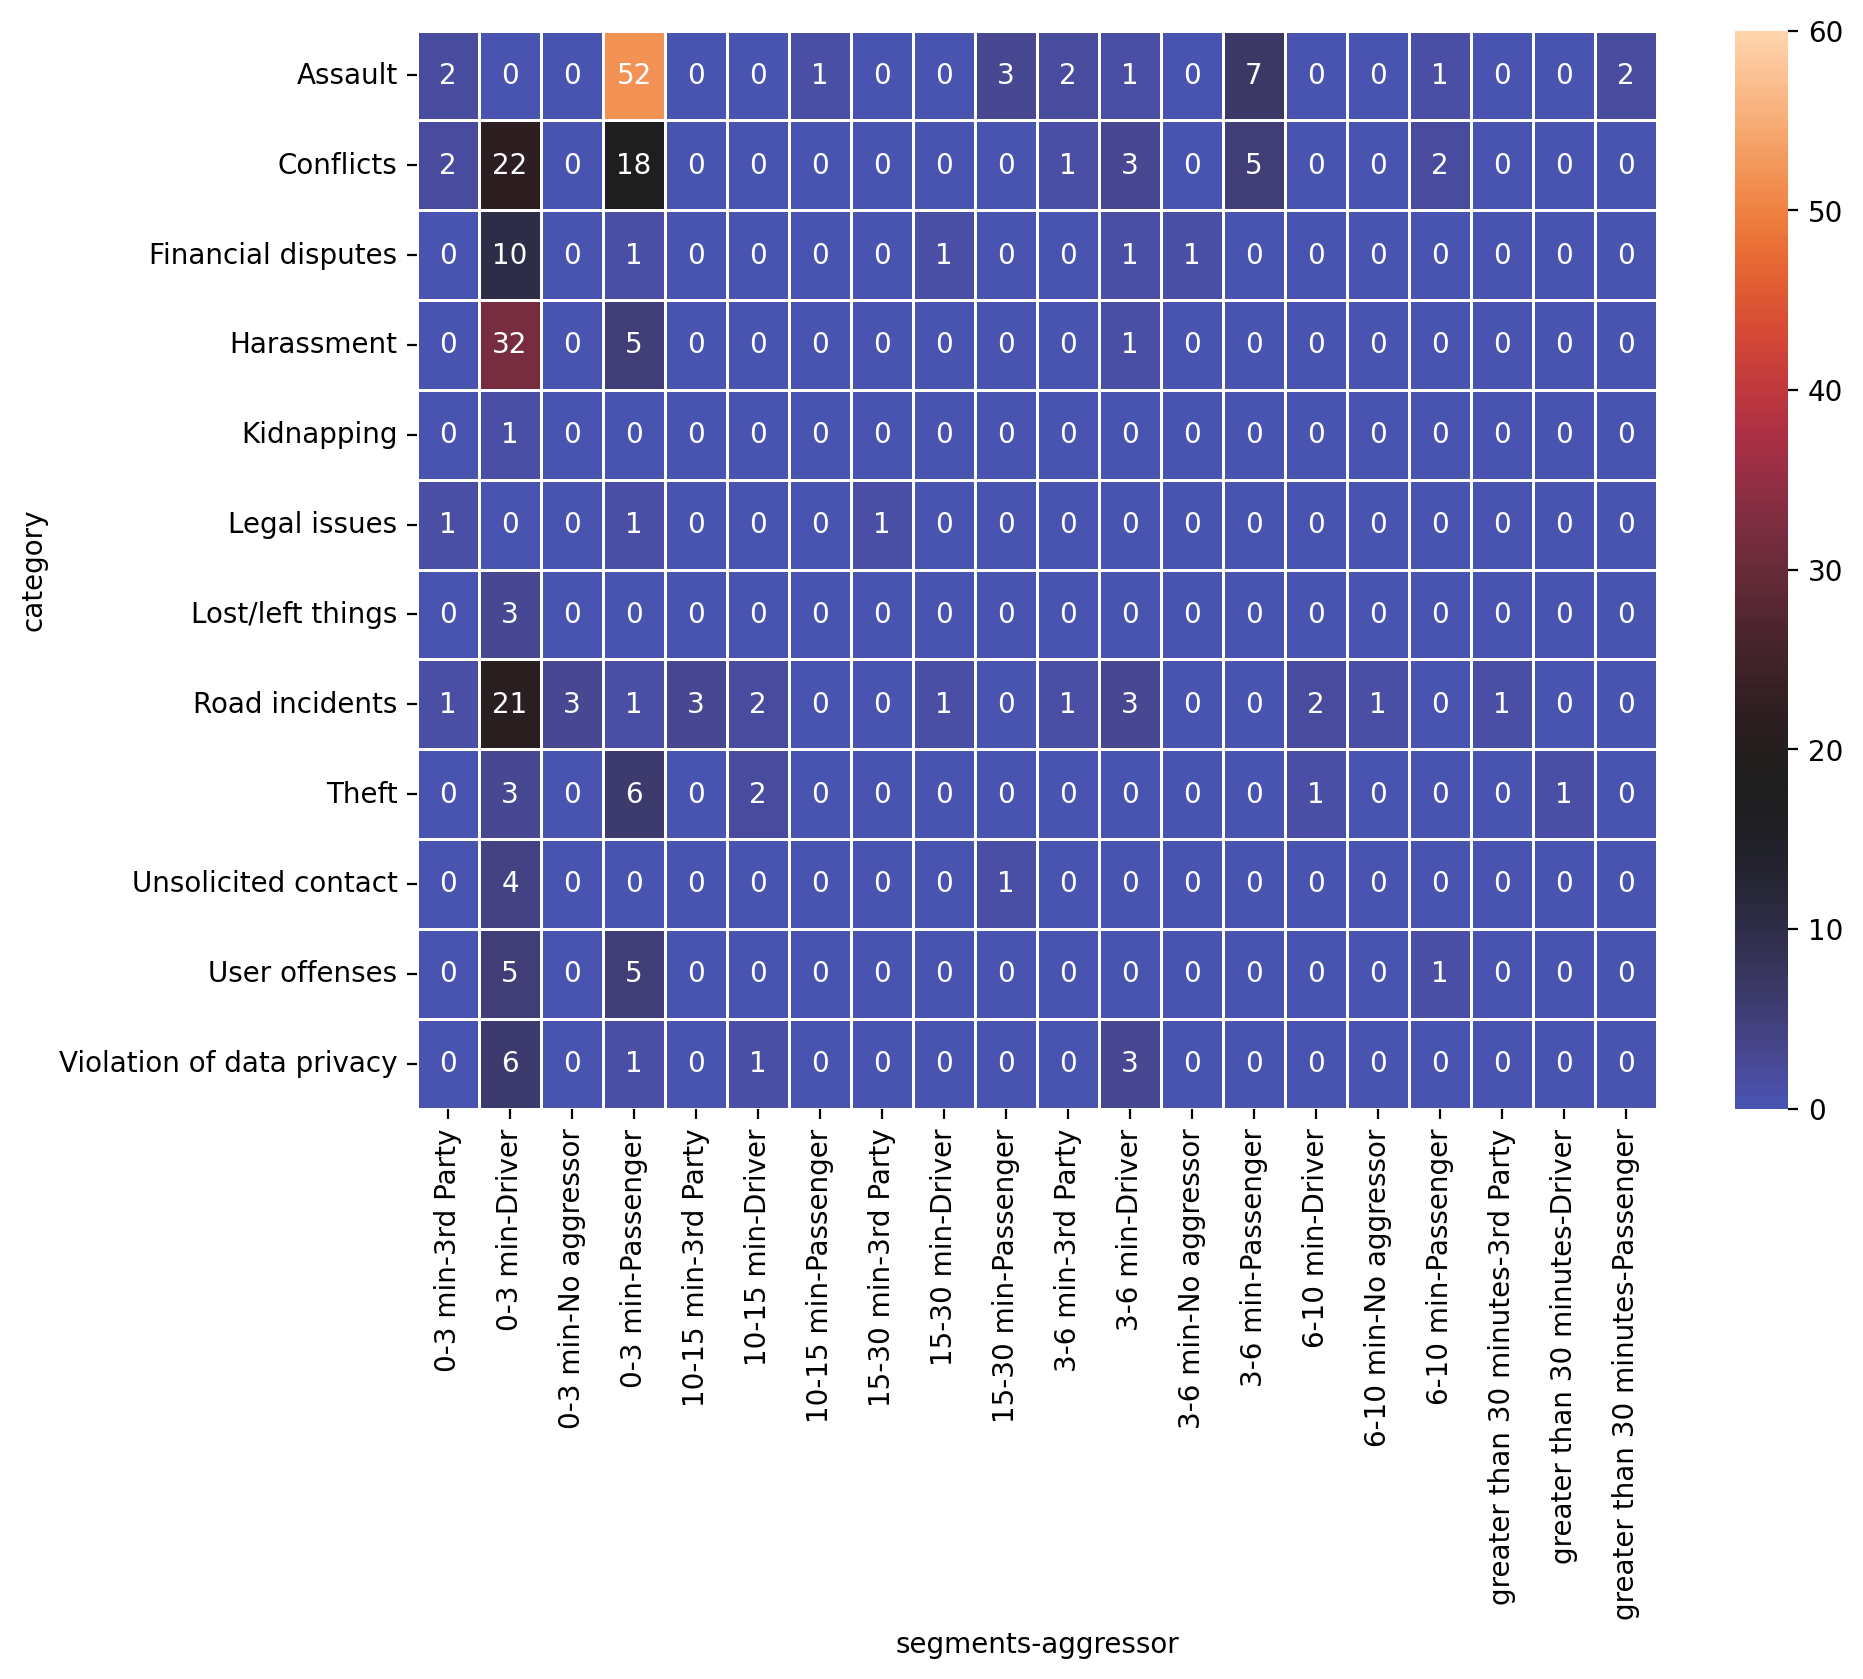

In [159]:
bins = [sec*60 for sec in range(15)]
labels = [bin for bin in range(1, 15)]

df_stop_ride['buckets'] = pd.cut(df_stop_ride['max_stop_duration_sec'], bins=bins, labels=labels)

fig, ax = plt.subplots(figsize=(10,7)) 

sns.heatmap(df_stop_ride[~df_stop_ride['redmine_id'].isna()].pivot_table(columns=['segments', 'aggressor'], index='category', values='redmine_id', aggfunc='count').fillna(0), 
            annot=True,
            linewidth=.5,
            # cmap = 'viridis',
            vmin = 0, vmax = 60, center = 18,
            square=False)


### Indicators by driver / pass within the ride

#### Drivers

In [ ]:
df_driver = read_bq("""
WITH dr AS (SELECT driver_id                                                                       AS user_id,
                   agg_period_dt_part,
                   (s11 + s12 + s21 + s22 + s121 + s30 + s40 + s51 + s52 + s60 + s70 + s80 + s990) AS standard_violation,
                   city_id,
                   country_id,
                   accepted_orders
            FROM dwh-storage-327422.emart_service_quality.incity_order_review_drivers_daily
            WHERE 1 = 1
              AND agg_period_dt_part >= '2024-12-01'
              AND city_id IN (5548, 4300, 4199, 4197, 169, 4373, 4524, 4142)),
     rides AS (SELECT user_type,
                      user_id,
                      country_id,
                      city_id,
                      metric_date_utc,
                      rides_count,
                      orders_count,
                      IF(LEAD(metric_date_utc)
                              OVER (PARTITION BY user_id ORDER BY metric_date_utc) IS NULL, CURRENT_DATE(),
                         LEAD(metric_date_utc)
                              OVER (PARTITION BY user_id ORDER BY metric_date_utc))                                             AS next_ride_date,
                      SUM(rides_count)
                          OVER (PARTITION BY user_id ORDER BY metric_date_utc ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_sum_of_rides,
                      SUM(orders_count)
                          OVER (PARTITION BY user_id ORDER BY metric_date_utc ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_sum_of_orders,
                      SUM(canceled_orders_count)
                          OVER (PARTITION BY user_id ORDER BY metric_date_utc ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_canceled_orders,
                      SUM(gmv_clean_usd)
                          OVER (PARTITION BY user_id ORDER BY metric_date_utc ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_sum_gmv_usd
               FROM (SELECT user_type,
                            user_id,
                            country_id,
                            city_id,
                            metric_date_utc,
                            SUM(rides_count)           AS rides_count,
                            SUM(orders_count)          AS orders_count,
                            SUM(canceled_orders_count) AS canceled_orders_count,
                            SUM(gmv_clean_usd)         AS gmv_clean_usd
                     FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                     GROUP BY 1, 2, 3, 4, 5)
               WHERE metric_date_utc >= '2024-12-01'
                 AND user_type = 'driver'
                 AND city_id IN (5548, 4300, 4199, 4197, 169, 4373, 4524, 4142)),
     personal AS (SELECT id                                          AS            user_id,
                         mode,
                         DATE(created)                                             registration_dt,
                         gender,
                         username,
                         IF(username IS NULL OR username = '', 0, 1) AS            username_flg,
                         IF(avatarmedium IS NOT NULL AND avatarmedium != '', 1, 0) avatar_flag
                  FROM dwh-storage-327422.personal_data.tbl_user_act
                  WHERE 1 = 1
                    AND mode = 'driver'
                    AND city_id IN (5548, 4300, 4199, 4197, 169, 4373, 4524, 4142)),
     incident AS (SELECT redmine_id
                       , incident_date
                       , vertical
                       , aggressor
                       , incident_type
                       , category
                       , city_id
                       , order_date
                       , city_name
                       , pass_id
                       , driver_id
                       , CASE
                             WHEN aggressor = 'Driver' THEN driver_id
                             WHEN aggressor = 'Passenger' THEN pass_id
                             ELSE NULL
             END aggressor_id
                  FROM indriver-bi.safety.vw_safety_incidents_detail
                  WHERE 1 = 1
                    AND incident_date >= DATE_ADD('2024-12-01', INTERVAL - 5 DAY)
                    AND aggressor = 'Driver'
                    AND information_status = 'Confirmed'
                    AND city_id IN (5548, 4300, 4199, 4197, 169, 4373, 4524, 4142)),
     rating AS (SELECT author_id,
                       target_id,
                       rating,
                       COUNT(rating)
                             OVER (PARTITION BY target_id ORDER BY created_date_part ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)                                                                                    AS rating_count,
                       SUM(rating) OVER (PARTITION BY target_id
                           ORDER BY created_date_part ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)                                                                                                                   AS rating_sum,
                       SAFE_DIVIDE(SUM(rating) OVER (PARTITION BY target_id
                           ORDER BY created_date_part ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW), COUNT(rating)
                                                                                                               OVER (PARTITION BY target_id ORDER BY created_date_part ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)) AS rating_avg,
                       created_date_part,
                       created_at,
                       city_id,
                       country_id
                FROM indriver-e6e40.ods_review.tbl_review
                WHERE visibility = 'driver'
                  AND city_id IN (5548, 4300, 4199, 4197, 169, 4373, 4524, 4142)
                  AND created_date_part >= '2024-12-01'
                  AND TYPE = 'new_order')
SELECT t1.*,
       t2.* EXCEPT (user_id, mode),
       COALESCE(SUM(t3.standard_violation)
                    OVER (PARTITION BY t1.user_id ORDER BY metric_date_utc ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW),
                0)                  AS cumulative_sum_violations,
       t4.target_id,
       t4.created_date_part,
       COALESCE(t4.rating, 0)       AS rating,
       COALESCE(t4.rating_count, 0) AS rating_count,
       COALESCE(t4.rating_sum, 0)   AS rating_sum,
       COALESCE(t4.rating_avg, 0)   AS rating_avg
FROM rides t1
         JOIN personal t2
              ON t1.user_id = t2.user_id
         LEFT JOIN dr t3
                   ON t1.user_id = t3.user_id
                       AND t3.agg_period_dt_part = t1.metric_date_utc
         LEFT JOIN rating t4
                   ON t1.user_id = t4.target_id
                       AND t1.metric_date_utc = t4.created_date_part
WHERE t1.user_id = 3587767
""")

#### Passengers

## Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import shap

# === ДАННЫЕ ===
# Загрузите свои данные (замените `your_data.csv` на ваш путь)
data = pd.read_csv("your_data.csv")

# === РАЗДЕЛЕНИЕ ДАННЫХ ПО ВОДИТЕЛЯМ ===
# Уникальные водители
drivers_summary = data.groupby('driver_id').agg({
    'incident': 'mean'  # Средний признак "инцидент" для стратификации
}).reset_index()

# Разделение водителей на обучающую и тестовую выборки
drivers_train, drivers_test = train_test_split(
    drivers_summary['driver_id'],
    test_size=0.3,
    stratify=drivers_summary['incident'],
    random_state=42
)

# Создание обучающей и тестовой выборок
train_data = data[data['driver_id'].isin(drivers_train)]
test_data = data[data['driver_id'].isin(drivers_test)]

# === ПОДГОТОВКА ДАННЫХ ===
# Факторы и целевая переменная
features = [
    'num_orders', 'driver_gender', 'total_amount', 
    'num_reviews', 'num_complaints', 'avg_rating',
    'num_stops', 'stop_duration', 'dangerous_time'
]
target = 'incident'

# Преобразование категориальных данных (если нужно)
train_data = pd.get_dummies(train_data, columns=['driver_gender', 'dangerous_time'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['driver_gender', 'dangerous_time'], drop_first=True)

# Обучающие и тестовые данные
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# === ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

log_probs = log_model.predict_proba(X_test)[:, 1]
log_preds = log_model.predict(X_test)

# === ДЕРЕВО РЕШЕНИЙ ===
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

tree_probs = tree_model.predict_proba(X_test)[:, 1]
tree_preds = tree_model.predict(X_test)

# === ОЦЕНКА МОДЕЛЕЙ ===
def evaluate_model(y_true, y_probs, y_preds, model_name):
    print(f"=== {model_name} ===")
    print("Classification Report:")
    print(classification_report(y_true, y_preds))
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_probs):.4f}")
    
    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_probs):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='best')
    plt.show()

# Оценка
evaluate_model(y_test, log_probs, log_preds, "Logistic Regression")
evaluate_model(y_test, tree_probs, tree_preds, "Decision Tree")

# === ГРАФИК SHAP ===
# SHAP для логистической регрессии
explainer = shap.Explainer(log_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

# === ВИЗУАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ ===
plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=features, class_names=['No Incident', 'Incident'], filled=True)
plt.show()
